In [1]:
import pandas as pd
import json
import textstat as txt
from itertools import groupby

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Loading TACRED dataset

In [2]:
train_data = json.load(open('./../tacred-relation-master/dataset/tacred/train.json'))
print("Number of Training instances :: {}".format(len(train_data)))

dev_data = json.load(open('./../tacred-relation-master/dataset/tacred/dev.json'))
print("Number of Dev instances :: {}".format(len(dev_data)))

test_data = json.load(open('./../tacred-relation-master/dataset/tacred/test.json'))
print("Number of Test instances :: {}".format(len(test_data)))

Number of Training instances :: 68124
Number of Dev instances :: 22631
Number of Test instances :: 15509


# Sentence Attributes

### Sentence Length

In [3]:
def generate_sentence_length_mapping(dataset):
    s_ids = []
    s_lens = []
    for eg in dataset:
        s_id = eg['id']
        tokens = eg['token']
        s_ids.append(s_id)
        s_lens.append(len(tokens))
    
    assert len(s_ids) == len(s_lens) 
    print(len(s_ids), len(s_lens) )
    df = pd.DataFrame({'sentence_id':s_ids, 'sentence_len':s_lens})
    return df

In [4]:
df_test_len = generate_sentence_length_mapping(test_data)
df_dev_len = generate_sentence_length_mapping(dev_data)

15509 15509
22631 22631


In [5]:
def convert_token(token):
    """ Convert PTB tokens to normal tokens """
    if (token.lower() == '-lrb-'):
            return '('
    elif (token.lower() == '-rrb-'):
        return ')'
    elif (token.lower() == '-lsb-'):
        return '['
    elif (token.lower() == '-rsb-'):
        return ']'
    elif (token.lower() == '-lcb-'):
        return '{'
    elif (token.lower() == '-rcb-'):
        return '}'
    return token

### Flesch-Kincaid Grade readability score

In [6]:
def generate_flesch_kincaid_grade(dataset):
    s_ids = []
    score = []
    for i, eg in enumerate(dataset, start=1):
        s_id = eg['id']
        tokens  = eg['token']
        sentence = ' '.join([convert_token(t) for t in tokens])
        s_ids.append(s_id)
        score.append(txt.flesch_kincaid_grade(sentence))
    assert len(s_ids) == len(score)
    print(len(s_ids), len(score))
    df = pd.DataFrame({'sentence_id':s_ids, 'f_k_score':score})
    return df

In [7]:
df_test_fk = generate_flesch_kincaid_grade(test_data)
df_dev_fk = generate_flesch_kincaid_grade(dev_data)

15509 15509
22631 22631


### Entity specific features

In [8]:
def generate_entity_specific_attribute(dataset):
    s_ids = []
    distance = []
    e_count = []
    for eg in dataset:
        s_id = eg['id']
        s_ids.append(s_id)
        s_start = eg['subj_start']
        s_end = eg['subj_end']
        o_start = eg['obj_start']
        o_end = eg['obj_end']
        s_type = eg['subj_type']
        o_type = eg['obj_type']
        subj = eg['token'][s_start:s_end+1]
        obj = eg['token'][o_start:o_end+1]
        # number of tokens between the subject and object entities
        if s_end < o_start:
            e_dist = o_start - s_end - 1
        elif o_end < s_start:
            e_dist = s_start - o_end - 1
        distance.append(e_dist)

        # Number of entities in the sentence based on stanford NER
        ner = eg['stanford_ner']
        s = e = 0
        n_e = 0
        p_et = None
        for i, et in enumerate(ner):
            if et == 'O':
                if e != 0:
                    n_e += 1
                    s = e = 0
                    p_et = None
                continue
            else:
                if p_et and p_et != et:
                    n_e += 1
                    s = e = 0
                    p_et = None
                s += 1
                e += 1
            p_et = et
        e_count.append(n_e)
    assert len(s_ids) == len(distance)
    assert len(s_ids) == len(e_count)
    print(len(s_ids), len(distance), len(e_count))
    df = pd.DataFrame({'sentence_id':s_ids, 'entities_distance':distance, 'entities_count':e_count})
    return df
            

In [9]:
df_test_ef = generate_entity_specific_attribute(test_data)
df_dev_ef = generate_entity_specific_attribute(dev_data)

15509 15509 15509
22631 22631 22631


## Loading TACREV dataset

In [10]:
tacrev_test = json.load(open('./tacrev_patch/test_patch.json'))

sentence_id = []
for item in tacrev_test:
    sentence_id.append(item['id'])
    
df_test = pd.DataFrame({'sentence_id':sentence_id})
# df_test

In [11]:
tacrev_dev = json.load(open('./tacrev_patch/dev_patch.json'))

sentence_id = []
for item in tacrev_dev:
    sentence_id.append(item['id'])
    
df_dev = pd.DataFrame({'sentence_id':sentence_id})
# df_dev

## Confidence for test data

In [12]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_test.tsv', sep='\t')
df1 = df1.loc[:,['sentence_id', 'confidence']]
df1 = df1.rename(columns={'confidence':'confidence_parnn'})

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_test.tsv', sep='\t')
df2 = df2.loc[:,['sentence_id', 'confidence']]
df2 = df2.rename(columns={'confidence': 'confidence_lstm'})

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/cgcn_test.tsv', sep='\t')
df3 = df3.loc[:,['sentence_id', 'confidence']]
df3 = df3.rename(columns={'confidence': 'confidence_gcn'})

dfconf = df1.merge(df2).merge(df3)
dfconf['confidence'] = (dfconf['confidence_parnn'] + dfconf['confidence_lstm'] + dfconf['confidence_gcn']) / 3
dfconf = dfconf.merge(df_test_len)
dfconf = dfconf.merge(df_test_fk)
dfconf = dfconf.merge(df_test_ef)
dfconf

,sentence_id,confidence_parnn,confidence_lstm,confidence_gcn,confidence,sentence_len,f_k_score,entities_distance,entities_count
0,098f665fb996b366ea9a,0.970,0.938,0.964,0.957333,46,26.8,16,4
1,098f65f2e855b721ff1d,0.977,0.971,0.633,0.860333,42,18.1,15,8
2,098f6179d3bb2b93c59d,0.998,0.994,0.995,0.995667,40,18.5,8,6
3,098f665fb97f78298f13,0.902,0.885,0.656,0.814333,40,8.8,11,6
4,098f65f2e8a5981f7177,0.832,0.948,0.622,0.800667,38,18.1,20,5
...,...,...,...,...,...,...,...,...,...
5241,098f637935c2aedcc397,0.982,0.990,0.985,0.985667,26,11.9,4,4
5242,098f6b1f1ad0911ae98e,0.582,0.956,0.946,0.828000,25,12.3,15,2
5243,098f6eb6b059a3ffe3b6,0.718,0.794,0.729,0.747000,23,8.3,1,4
5244,098f665fb946361bf0c0,0.711,0.925,0.988,0.874667,11,6.4,2,2


In [13]:
# for eg in test_data:
#     if eg['id'] == '098f65f2e8bdbdda0160':
#         print(eg)
#         break

In [14]:
# for eg in test_data:
#     if eg['id'] == '098f6f12fda67717c4bf':
#         print(eg)
#         break    

In [15]:
# for eg in dev_data:
#     if eg['id'] == 'e779865fb97de8634173':
#         print(len(eg['token']))
#         print(' '.join(eg['token']))
#         break

In [ ]:
df.to_csv('confidence_test.tsv', sep='\t')

In [13]:
sorted_dfconf = dfconf.sort_values(by=['confidence'], ascending=False)

In [14]:
freq_c = []
for i in range(len(sorted_dfconf)):
    n_dp = len(df_test.merge(sorted_dfconf[:i]))
    freq_c.append(n_dp)

In [15]:
len(freq_c)

5246

## Confidence for dev data

In [16]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_dev.tsv', sep='\t')
df1 = df1.loc[:,['sentence_id', 'confidence']]
df1 = df1.rename(columns={'confidence':'confidence_parnn'})

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_dev.tsv', sep='\t')
df2 = df2.loc[:,['sentence_id', 'confidence']]
df2 = df2.rename(columns={'confidence': 'confidence_lstm'})

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/cgcn_dev.tsv', sep='\t')
df3 = df3.loc[:,['sentence_id', 'confidence']]
df3 = df3.rename(columns={'confidence': 'confidence_gcn'})

dfconf_dev = df1.merge(df2).merge(df3)
dfconf_dev['confidence'] = (dfconf_dev['confidence_parnn'] + dfconf_dev['confidence_lstm'] + dfconf_dev['confidence_gcn']) / 3
dfconf_dev = dfconf_dev.merge(df_dev_len)
dfconf_dev = dfconf_dev.merge(df_dev_fk)
dfconf_dev = dfconf_dev.merge(df_dev_ef)
dfconf_dev

,sentence_id,confidence_parnn,confidence_lstm,confidence_gcn,confidence,sentence_len,f_k_score,entities_distance,entities_count
0,e779865fb97de8634173,0.856,0.887,0.821,0.854667,79,12.9,1,14
1,e77985158d81b7d6ea9a,0.999,0.999,0.999,0.999000,61,25.9,51,11
2,e779865fb94919ad3d94,0.897,0.868,0.836,0.867000,48,20.5,36,12
3,e779889f60eb8da1ff1d,1.000,1.000,1.000,1.000000,46,18.5,5,5
4,e779865fb967697d9d4f,0.835,0.907,0.877,0.873000,43,19.7,8,8
...,...,...,...,...,...,...,...,...,...
8665,e7798b11b9f18a5a5d16,0.635,0.968,0.465,0.689333,33,14.6,3,7
8666,e779865fb998135f4ac4,0.858,0.804,0.869,0.843667,24,11.1,18,6
8667,e779889f6039db57be54,0.994,0.989,0.977,0.986667,23,9.5,1,6
8668,e779865fb9da7057a42c,0.937,0.636,0.661,0.744667,21,10.3,5,1


In [ ]:
df.to_csv('confidence_dev.tsv', sep='\t')

In [17]:
sorted_dfconf_dev = dfconf_dev.sort_values(by=['confidence'], ascending=False)

In [18]:
dev_freq_c = []
for i in range(len(sorted_dfconf_dev)):
    n_dp = len(df_dev.merge(sorted_dfconf_dev[:i]))
    dev_freq_c.append(n_dp)

In [19]:
len(dev_freq_c)

8670

## Prediction distance from ground truth on test data

In [21]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_test.tsv', sep='\t')
df1 = df1.loc[:,['sentence_id', 'd_prediction']]
df1 = df1.rename(columns={'d_prediction':'d_prediction_parnn'})

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_test.tsv', sep='\t')
df2 = df2.loc[:,['sentence_id', 'd_prediction']]
df2 = df2.rename(columns={'d_prediction': 'd_prediction_lstm'})

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/cgcn_test.tsv', sep='\t')
df3 = df3.loc[:,['sentence_id', 'd_prediction']]
df3 = df3.rename(columns={'d_prediction': 'd_prediction_gcn'})

df_pd = df1.merge(df2).merge(df3)
df_pd['d_prediction'] = (df_pd['d_prediction_parnn'] + df_pd['d_prediction_lstm'] + df_pd['d_prediction_gcn']) / 3
df_pd = df_pd.merge(df_test_len)
df_pd = df_pd.merge(df_test_fk)
df_pd = df_pd.merge(df_test_ef)
df_pd

,sentence_id,d_prediction_parnn,d_prediction_lstm,d_prediction_gcn,d_prediction,sentence_len,f_k_score,entities_distance,entities_count
0,098f665fb996b366ea9a,5,5,5,5.0,46,26.8,16,4
1,098f65f2e855b721ff1d,5,5,5,5.0,42,18.1,15,8
2,098f6179d3bb2b93c59d,6,6,6,6.0,40,18.5,8,6
3,098f665fb97f78298f13,5,5,5,5.0,40,8.8,11,6
4,098f65f2e8a5981f7177,5,5,5,5.0,38,18.1,20,5
...,...,...,...,...,...,...,...,...,...
5241,098f637935c2aedcc397,5,5,5,5.0,26,11.9,4,4
5242,098f6b1f1ad0911ae98e,2,2,2,2.0,25,12.3,15,2
5243,098f6eb6b059a3ffe3b6,5,5,5,5.0,23,8.3,1,4
5244,098f665fb946361bf0c0,5,5,5,5.0,11,6.4,2,2


In [ ]:
df.to_csv('d_prediction_test.tsv', sep='\t')

In [22]:
sorted_df_pd = df_pd.sort_values(by=['d_prediction'], ascending=False)

In [23]:
freq_p = []
for i in range(len(sorted_df_pd)):
    n_dp = len(df_test.merge(sorted_df_pd[:i]))
    freq_p.append(n_dp)

In [24]:
len(freq_p)

5246

# Prediction distance from ground truth on dev data

In [25]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_dev.tsv', sep='\t')
df1 = df1.loc[:,['sentence_id', 'd_prediction']]
df1 = df1.rename(columns={'d_prediction':'d_prediction_parnn'})

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_dev.tsv', sep='\t')
df2 = df2.loc[:,['sentence_id', 'd_prediction']]
df2 = df2.rename(columns={'d_prediction': 'd_prediction_lstm'})

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/cgcn_dev.tsv', sep='\t')
df3 = df3.loc[:,['sentence_id', 'd_prediction']]
df3 = df3.rename(columns={'d_prediction': 'd_prediction_gcn'})

df_pd_dev = df1.merge(df2).merge(df3)
df_pd_dev['d_prediction'] = (df_pd_dev['d_prediction_parnn'] + df_pd_dev['d_prediction_lstm'] + df_pd_dev['d_prediction_gcn']) / 3
df_pd_dev = df_pd_dev.merge(df_dev_len)
df_pd_dev = df_pd_dev.merge(df_dev_fk)
df_pd_dev = df_pd_dev.merge(df_dev_ef)
df_pd_dev

,sentence_id,d_prediction_parnn,d_prediction_lstm,d_prediction_gcn,d_prediction,sentence_len,f_k_score,entities_distance,entities_count
0,e779865fb97de8634173,5,5,5,5.0,79,12.9,1,14
1,e77985158d81b7d6ea9a,6,6,6,6.0,61,25.9,51,11
2,e779865fb94919ad3d94,5,5,5,5.0,48,20.5,36,12
3,e779889f60eb8da1ff1d,4,4,4,4.0,46,18.5,5,5
4,e779865fb967697d9d4f,6,6,6,6.0,43,19.7,8,8
...,...,...,...,...,...,...,...,...,...
8665,e7798b11b9f18a5a5d16,5,5,5,5.0,33,14.6,3,7
8666,e779865fb998135f4ac4,5,5,5,5.0,24,11.1,18,6
8667,e779889f6039db57be54,5,5,5,5.0,23,9.5,1,6
8668,e779865fb9da7057a42c,5,5,5,5.0,21,10.3,5,1


In [ ]:
df.to_csv('d_prediction_dev.tsv', sep='\t')

In [26]:
sorted_df_pd_dev = df_pd_dev.sort_values(by=['d_prediction'], ascending=False)

In [27]:
dev_freq_p = []
for i in range(len(sorted_df_pd_dev)):
    n_dp = len(df_dev.merge(sorted_df_pd_dev[:i]))
    dev_freq_p.append(n_dp)

In [28]:
len(dev_freq_p)

8670

## Prediction distance from lca test data

In [30]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_test.tsv', sep='\t')
df1 = df1.loc[:,['sentence_id', 'd_lca']]
df1 = df1.rename(columns={'d_lca':'d_lca_parnn'})

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_test.tsv', sep='\t')
df2 = df2.loc[:,['sentence_id', 'd_lca']]
df2 = df2.rename(columns={'d_lca': 'd_lca_lstm'})

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/cgcn_test.tsv', sep='\t')
df3 = df3.loc[:,['sentence_id', 'd_lca']]
df3 = df3.rename(columns={'d_lca': 'd_lca_gcn'})

dflca = df1.merge(df2).merge(df3)
dflca['d_lca'] = (dflca['d_lca_parnn'] + dflca['d_lca_lstm'] + dflca['d_lca_gcn']) / 3
dflca = dflca.merge(df_test_len)
dflca = dflca.merge(df_test_fk)
dflca = dflca.merge(df_test_ef)
dflca

,sentence_id,d_lca_parnn,d_lca_lstm,d_lca_gcn,d_lca,sentence_len,f_k_score,entities_distance,entities_count
0,098f665fb996b366ea9a,1,1,1,1.0,46,26.8,16,4
1,098f65f2e855b721ff1d,4,4,4,4.0,42,18.1,15,8
2,098f6179d3bb2b93c59d,5,5,5,5.0,40,18.5,8,6
3,098f665fb97f78298f13,1,1,1,1.0,40,8.8,11,6
4,098f65f2e8a5981f7177,4,4,4,4.0,38,18.1,20,5
...,...,...,...,...,...,...,...,...,...
5241,098f637935c2aedcc397,4,4,4,4.0,26,11.9,4,4
5242,098f6b1f1ad0911ae98e,1,1,1,1.0,25,12.3,15,2
5243,098f6eb6b059a3ffe3b6,2,2,2,2.0,23,8.3,1,4
5244,098f665fb946361bf0c0,1,1,1,1.0,11,6.4,2,2


In [ ]:
df.to_csv('d_lca_test.tsv', sep='\t')

In [31]:
sorted_dflca = dflca.sort_values(by=['d_lca'], ascending=False)

In [32]:
freq_l = []
for i in range(len(sorted_dflca)):
    n_dp = len(df_test.merge(sorted_dflca[:i]))
    freq_l.append(n_dp)

In [33]:
len(freq_l)

5246

# Prediction distance from lca dev data

In [34]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_dev.tsv', sep='\t')
df1 = df1.loc[:,['sentence_id', 'd_lca']]
df1 = df1.rename(columns={'d_lca':'d_lca_parnn'})

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_dev.tsv', sep='\t')
df2 = df2.loc[:,['sentence_id', 'd_lca']]
df2 = df2.rename(columns={'d_lca': 'd_lca_lstm'})

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/cgcn_dev.tsv', sep='\t')
df3 = df3.loc[:,['sentence_id', 'd_lca']]
df3 = df3.rename(columns={'d_lca': 'd_lca_gcn'})

dflca_dev = df1.merge(df2).merge(df3)
dflca_dev['d_lca'] = (dflca_dev['d_lca_parnn'] + dflca_dev['d_lca_lstm'] + dflca_dev['d_lca_gcn']) / 3
dflca_dev = dflca_dev.merge(df_dev_len)
dflca_dev = dflca_dev.merge(df_dev_fk)
dflca_dev = dflca_dev.merge(df_dev_ef)
dflca_dev

,sentence_id,d_lca_parnn,d_lca_lstm,d_lca_gcn,d_lca,sentence_len,f_k_score,entities_distance,entities_count
0,e779865fb97de8634173,1,1,1,1.000000,79,12.9,1,14
1,e77985158d81b7d6ea9a,5,5,5,5.000000,61,25.9,51,11
2,e779865fb94919ad3d94,1,1,1,1.000000,48,20.5,36,12
3,e779889f60eb8da1ff1d,2,2,2,2.000000,46,18.5,5,5
4,e779865fb967697d9d4f,1,1,1,1.000000,43,19.7,8,8
...,...,...,...,...,...,...,...,...,...
8665,e7798b11b9f18a5a5d16,2,4,4,3.333333,33,14.6,3,7
8666,e779865fb998135f4ac4,1,1,1,1.000000,24,11.1,18,6
8667,e779889f6039db57be54,4,4,4,4.000000,23,9.5,1,6
8668,e779865fb9da7057a42c,1,1,1,1.000000,21,10.3,5,1


In [ ]:
df.to_csv('d_lca_dev.tsv', sep='\t')

In [35]:
sorted_dflca_dev = dflca_dev.sort_values(by=['d_lca'], ascending=False)

In [36]:
dev_freq_l = []
for i in range(len(sorted_dflca_dev)):
    n_dp = len(df_dev.merge(sorted_dflca_dev[:i]))
    dev_freq_l.append(n_dp)

In [37]:
len(dev_freq_l)

8670

# Ratio of Distance on test

In [ ]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_test.tsv', sep='\t')
df1['d_l/d_p'] = df1['d_lca'] / df1['d_prediction']
df1 = df1.loc[:, ['sentence_id', 'd_l/d_p']]
df1 = df1.rename(columns={'d_l/d_p':'d_l/d_p_parnn'})

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_test.tsv', sep='\t')
df2['d_l/d_p'] = df2['d_lca'] / df2['d_prediction']
df2 = df2.loc[:, ['sentence_id', 'd_l/d_p']]
df2 = df2.rename(columns={'d_l/d_p':'d_l/d_p_lstm'})

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/gcn_test.tsv', sep='\t')
df3['d_l/d_p'] = df3['d_lca'] / df3['d_prediction']
df3 = df3.loc[:, ['sentence_id', 'd_l/d_p']]
df3 = df3.rename(columns={'d_l/d_p':'d_l/d_p_gcn'})

df = df1.merge(df2).merge(df3)
df['d_l/d_p'] = (df['d_l/d_p_parnn'] + df['d_l/d_p_lstm'] + df['d_l/d_p_gcn']) / 3
df = df.merge(df_test_len)
df = df.merge(df_test_fk)
df = df.merge(df_test_ef)
df

In [ ]:
df.to_csv('d_ratio_test.tsv', sep='\t')

In [ ]:
sorted_df = df.sort_values(by=['d_l/d_p'], ascending=False)

In [ ]:
df_test.merge(sorted_df[:100])

# Ratio of distance on dev

In [ ]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_dev.tsv', sep='\t')
df1['d_l/d_p'] = df1['d_lca'] / df1['d_prediction']
df1 = df1.loc[:, ['sentence_id', 'd_l/d_p']]
df1 = df1.rename(columns={'d_l/d_p':'d_l/d_p_parnn'})

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_dev.tsv', sep='\t')
df2['d_l/d_p'] = df2['d_lca'] / df2['d_prediction']
df2 = df2.loc[:, ['sentence_id', 'd_l/d_p']]
df2 = df2.rename(columns={'d_l/d_p':'d_l/d_p_lstm'})

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/gcn_dev.tsv', sep='\t')
df3['d_l/d_p'] = df3['d_lca'] / df3['d_prediction']
df3 = df3.loc[:, ['sentence_id', 'd_l/d_p']]
df3 = df3.rename(columns={'d_l/d_p':'d_l/d_p_gcn'})

df = df1.merge(df2).merge(df3)
df['d_l/d_p'] = (df['d_l/d_p_parnn'] + df['d_l/d_p_lstm'] + df['d_l/d_p_gcn']) / 3
df = df.merge(df_dev_len)
df = df.merge(df_dev_fk)
df = df.merge(df_dev_ef)
df

In [ ]:
df.to_csv('d_ratio_dev.tsv', sep='\t')

In [ ]:
sorted_df = df.sort_values(by=['d_l/d_p'], ascending=False)

In [ ]:
df_dev.merge(sorted_df[:3000])

### Visualising Strategies

Text(0.5, 1.0, 'Test Dataset')

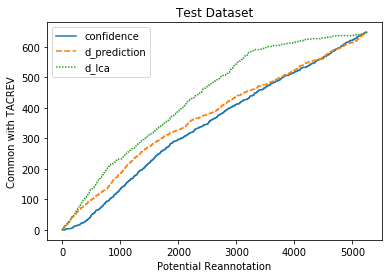

In [39]:
freq = pd.DataFrame({'confidence':freq_c, 'd_prediction':freq_p, 'd_lca':freq_l})
plt.figure()
sns.lineplot(data=freq)
plt.ylabel('Common with TACREV')
plt.xlabel('Potential Reannotation')
plt.title('Test Dataset')

Text(0.5, 1.0, 'Dev Dataset')

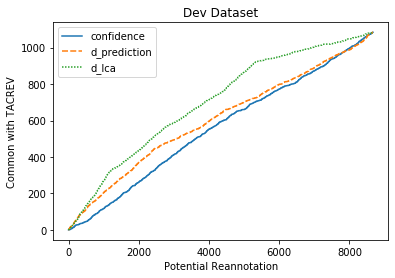

In [40]:
dev_freq = pd.DataFrame({'confidence':dev_freq_c, 'd_prediction':dev_freq_p, 'd_lca':dev_freq_l})
plt.figure()
sns.lineplot(data=dev_freq)
plt.ylabel('Common with TACREV')
plt.xlabel('Potential Reannotation')
plt.title('Dev Dataset')

In [ ]:
plt.figure()
plt.scatter(range(len(freq)), np.array(freq.confidence), marker='o')
plt.scatter(range(len(freq)), np.array(freq.d_prediction), marker='+')
plt.scatter(range(len(freq)), np.array(freq.d_lca), marker='x')

# Visualization of correct and incorrect predictions

## Test Data

In [46]:
df1 = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_test.tsv', sep='\t')
df1['correctness'] = 0
df1['model'] = 'parnn'
df1 = df1.merge(df_test_len)
df1 = df1.merge(df_test_fk)
df1 = df1.merge(df_test_ef)

# df1c = pd.read_csv('crct_parnn_test.tsv', sep='\t')
# df1c['correctness'] = 1
# df1c['model'] = 'parnn'
# df1c = df1c.merge(df_test_len)
# df1c = df1c.merge(df_test_fk)
# df1c = df1c.merge(df_test_ef)

df2 = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_test.tsv', sep='\t')
df2['correctness'] = 0
df2['model'] = 'lstm'
df2 = df2.merge(df_test_len)
df2 = df2.merge(df_test_fk)
df2 = df2.merge(df_test_ef)

# df2c = pd.read_csv('crct_lstm_test.tsv', sep='\t')
# df2c['correctness'] = 1
# df2c['model'] = 'lstm'
# df2c = df2c.merge(df_test_len)
# df2c = df2c.merge(df_test_fk)
# df2c = df2c.merge(df_test_ef)

df3 = pd.read_csv('./filtered_dataset_results_10_2_2021/cgcn_test.tsv', sep='\t')
df3['correctness'] = 0
df3['model'] = 'cgcn'
df3 = df3.merge(df_test_len)
df3 = df3.merge(df_test_fk)
df3 = df3.merge(df_test_ef)

# df3c = pd.read_csv('crct_cgcn_test.tsv', sep='\t')
# df3c['correctness'] = 1
# df3c['model'] = 'cgcn'
# df3c = df3c.merge(df_test_len)
# df3c = df3c.merge(df_test_fk)
# df3c = df3c.merge(df_test_ef)

In [73]:
data1 = df1.append(df1c, ignore_index=True)
data2 = df2.append(df2c, ignore_index=True)
data3 = df3.append(df3c, ignore_index=True)

NameError: name 'data1' is not defined

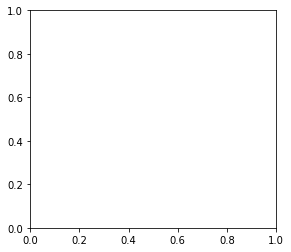

In [62]:
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
ax1 = sns.violinplot(data=data1, x='correctness', y='sentence_len')
ax1 = plt.title('PARNN')

ax2 = plt.subplot(132)
ax2 = sns.violinplot(data=data2, x='correctness', y='sentence_len')
ax2 = plt.title('LSTM')

ax3 = plt.subplot(133)
ax3 = sns.violinplot(data=data3, x='sentence_len', y='correctness')
ax3 = plt.title('CGCN')

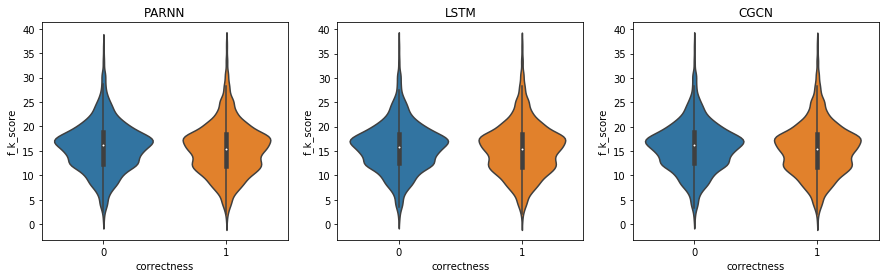

In [75]:
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
ax1 = sns.violinplot(data=data1, x='correctness', y='f_k_score')
ax1 = plt.title('PARNN')

ax2 = plt.subplot(132)
ax2 = sns.violinplot(data=data2, x='correctness', y='f_k_score')
ax2 = plt.title('LSTM')

ax3 = plt.subplot(133)
ax3 = sns.violinplot(data=data3, x='correctness', y='f_k_score')
ax3 = plt.title('CGCN')

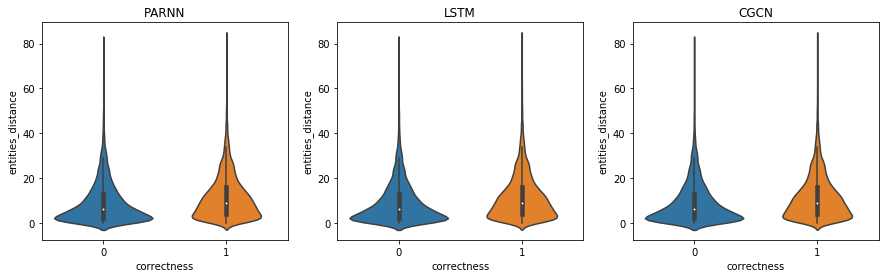

In [76]:
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
ax1 = sns.violinplot(data=data1, x='correctness', y='entities_distance')
ax1 = plt.title('PARNN')

ax2 = plt.subplot(132)
ax2 = sns.violinplot(data=data2, x='correctness', y='entities_distance')
ax2 = plt.title('LSTM')

ax3 = plt.subplot(133)
ax3 = sns.violinplot(data=data3, x='correctness', y='entities_distance')
ax3 = plt.title('CGCN')

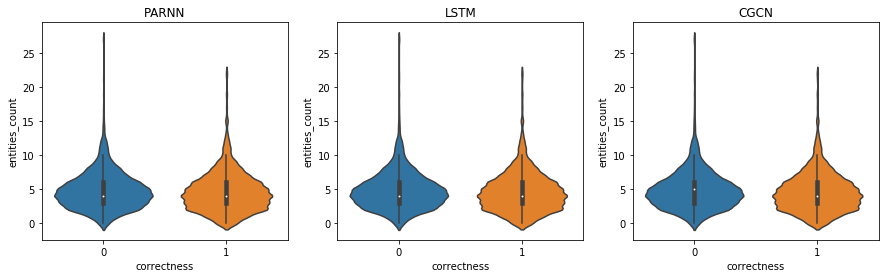

In [77]:
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
ax1 = sns.violinplot(data=data1, x='correctness', y='entities_count')
ax1 = plt.title('PARNN')

ax2 = plt.subplot(132)
ax2 = sns.violinplot(data=data2, x='correctness', y='entities_count')
ax2 = plt.title('LSTM')

ax3 = plt.subplot(133)
ax3 = sns.violinplot(data=data3, x='correctness', y='entities_count')
ax3 = plt.title('CGCN')

## Dev data

In [47]:
df1_dev = pd.read_csv('./filtered_dataset_results_10_2_2021/parnn_dev.tsv', sep='\t')
df1_dev['correctness'] = 0
df1_dev['model'] = 'parnn'
df1_dev = df1_dev.merge(df_dev_len)
df1_dev = df1_dev.merge(df_dev_fk)
df1_dev = df1_dev.merge(df_dev_ef)

# df1c_dev = pd.read_csv('crct_parnn_dev.tsv', sep='\t')
# df1c_dev['correctness'] = 1
# df1c_dev['model'] = 'parnn'
# df1c_dev = df1c_dev.merge(df_dev_len)
# df1c_dev = df1c_dev.merge(df_dev_fk)
# df1c_dev = df1c_dev.merge(df_dev_ef)


df2_dev = pd.read_csv('./filtered_dataset_results_10_2_2021/lstm_dev.tsv', sep='\t')
df2_dev['correctness'] = 0
df2_dev['model'] = 'lstm'
df2_dev = df2_dev.merge(df_dev_len)
df2_dev = df2_dev.merge(df_dev_fk)
df2_dev = df2_dev.merge(df_dev_ef)

# df2c_dev = pd.read_csv('crct_lstm_dev.tsv', sep='\t')
# df2c_dev['correctness'] = 1
# df2c_dev['model'] = 'lstm'
# df2c_dev = df2c_dev.merge(df_dev_len)
# df2c_dev = df2c_dev.merge(df_dev_fk)
# df2c_dev = df2c_dev.merge(df_dev_ef)

df3_dev = pd.read_csv('./filtered_dataset_results_10_2_2021/cgcn_dev.tsv', sep='\t')
df3_dev['correctness'] = 0
df3_dev['model'] = 'cgcn'
df3_dev = df3_dev.merge(df_dev_len)
df3_dev = df3_dev.merge(df_dev_fk)
df3_dev = df3_dev.merge(df_dev_ef)

# df3c_dev = pd.read_csv('crct_cgcn_dev.tsv', sep='\t')
# df3c_dev['correctness'] = 1
# df3c_dev['model'] = 'cgcn'
# df3c_dev = df3c_dev.merge(df_dev_len)
# df3c_dev = df3c_dev.merge(df_dev_fk)
# df3c_dev = df3c_dev.merge(df_dev_ef)

In [79]:
data1_dev = df1_dev.append(df1c_dev, ignore_index=True)
data2_dev = df2_dev.append(df2c_dev, ignore_index=True)
data3_dev = df3_dev.append(df3c_dev, ignore_index=True)

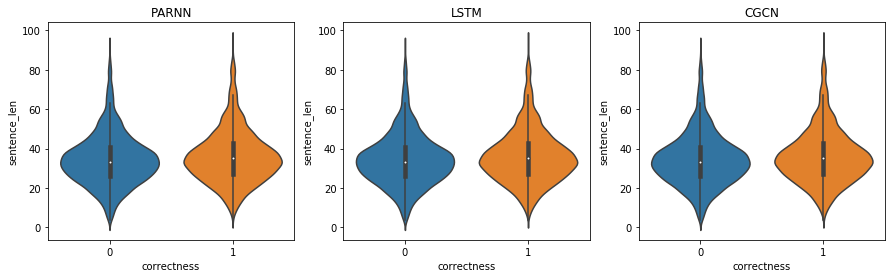

In [85]:
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
ax1 = sns.violinplot(data=data1_dev, x='correctness', y='sentence_len')
ax1 = plt.title('PARNN')

ax2 = plt.subplot(132)
ax2 = sns.violinplot(data=data2_dev, x='correctness', y='sentence_len')
ax2 = plt.title('LSTM')

ax3 = plt.subplot(133)
ax3 = sns.violinplot(data=data3_dev, x='correctness', y='sentence_len')
ax3 = plt.title('CGCN')

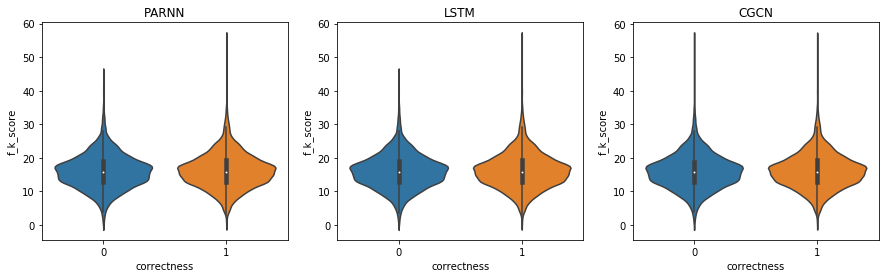

In [86]:
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
ax1 = sns.violinplot(data=data1_dev, x='correctness', y='f_k_score')
ax1 = plt.title('PARNN')

ax2 = plt.subplot(132)
ax2 = sns.violinplot(data=data2_dev, x='correctness', y='f_k_score')
ax2 = plt.title('LSTM')

ax3 = plt.subplot(133)
ax3 = sns.violinplot(data=data3_dev, x='correctness', y='f_k_score')
ax3 = plt.title('CGCN')

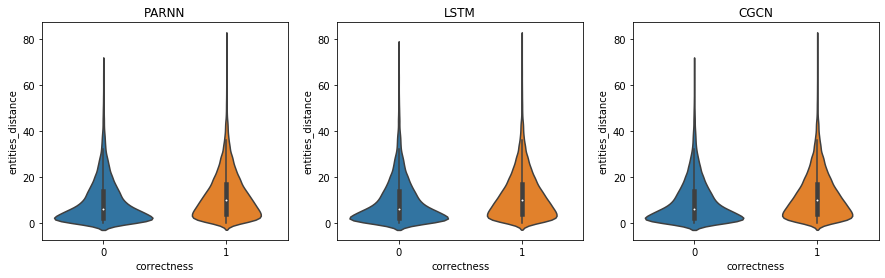

In [84]:
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
ax1 = sns.violinplot(data=data1_dev, x='correctness', y='entities_distance')
ax1 = plt.title('PARNN')

ax2 = plt.subplot(132)
ax2 = sns.violinplot(data=data2_dev, x='correctness', y='entities_distance')
ax2 = plt.title('LSTM')

ax3 = plt.subplot(133)
ax3 = sns.violinplot(data=data3_dev, x='correctness', y='entities_distance')
ax3 = plt.title('CGCN')

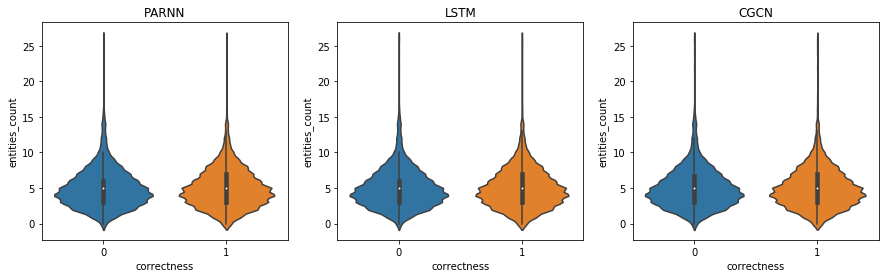

In [87]:
fig = plt.figure(figsize=(15,4))

ax1 = plt.subplot(131)
ax1 = sns.violinplot(data=data1_dev, x='correctness', y='entities_count')
ax1 = plt.title('PARNN')

ax2 = plt.subplot(132)
ax2 = sns.violinplot(data=data2_dev, x='correctness', y='entities_count')
ax2 = plt.title('LSTM')

ax3 = plt.subplot(133)
ax3 = sns.violinplot(data=data3_dev, x='correctness', y='entities_count')
ax3 = plt.title('CGCN')

# Identifying label change in TACREV

In [48]:
LABEL_TO_ID = {'no_relation': 0, 'per:title': 1, 'org:top_members/employees': 2, 'per:employee_of': 3, 'org:alternate_names': 4, 'org:country_of_headquarters': 5, 'per:countries_of_residence': 6, 'org:city_of_headquarters': 7, 'per:cities_of_residence': 8, 'per:age': 9, 'per:stateorprovinces_of_residence': 10, 'per:origin': 11, 'org:subsidiaries': 12, 'org:parents': 13, 'per:spouse': 14, 'org:stateorprovince_of_headquarters': 15, 'per:children': 16, 'per:other_family': 17, 'per:alternate_names': 18, 'org:members': 19, 'per:siblings': 20, 'per:schools_attended': 21, 'per:parents': 22, 'per:date_of_death': 23, 'org:member_of': 24, 'org:founded_by': 25, 'org:website': 26, 'per:cause_of_death': 27, 'org:political/religious_affiliation': 28, 'org:founded': 29, 'per:city_of_death': 30, 'org:shareholders': 31, 'org:number_of_employees/members': 32, 'per:date_of_birth': 33, 'per:city_of_birth': 34, 'per:charges': 35, 'per:stateorprovince_of_death': 36, 'per:religion': 37, 'per:stateorprovince_of_birth': 38, 'per:country_of_birth': 39, 'org:dissolved': 40, 'per:country_of_death': 41, 'per:nationality': 42, 'org:location_of_headquarters':43, 'per:location_of_birth':44, 'per:location_of_death':45, 'per:location_of_residence':46, 'per:family':47, 'per-per':48, 'per-org':49, 'per-misc':50, 'per-loc':51, 'org-per':52, 'org-org':53, 'org-misc':54, 'org-loc':55, 'per':56, 'org':57, 'relation':58, 'root':59}

## Test Data

In [49]:
tacrev_test = pd.read_json('./tacrev_patch/test_patch.json')
tacrev_test['relation'] = [LABEL_TO_ID[rel] for rel in list(tacrev_test['relation'])]
tacrev_test = tacrev_test.rename(columns={'id':'sentence_id'})
tacrev_test

,sentence_id,relation
0,098f65f2e846a27c74d9,0
1,098f65f2e855b721ff1d,0
2,098f65f2e8ba867c7e12,0
3,098f6179d38f23a06905,0
4,098f665fb9b90ac0a09c,9
...,...,...
931,098f64ffc90811980f0f,6
932,098f665fb95d9daccf2d,3
933,098f665fb9db10b56707,3
934,098f6b1f1ad0911ae98e,0


In [50]:
tt_dict = dict(zip(tacrev_test.sentence_id, tacrev_test.relation))
tt_dict

{'098f65f2e846a27c74d9': 0,
 '098f65f2e855b721ff1d': 0,
 '098f65f2e8ba867c7e12': 0,
 '098f6179d38f23a06905': 0,
 '098f665fb9b90ac0a09c': 9,
 '098f6379357a2a2a5e00': 0,
 '098f6e546cd56bc006f5': 0,
 '098f6179d387bf7bf822': 0,
 '098f665fb9d08796cdd6': 27,
 '098f60af8fdaab69dcb8': 0,
 '098f65f2e8fc258e1654': 0,
 '098f6e546c5d440289df': 0,
 '098f65f2e85978e91889': 0,
 '098f665fb9bdd6f6c988': 10,
 '098f665fb963d544734b': 1,
 '098f6f09754f304d947b': 0,
 '098f66c8900bb2f48aed': 0,
 '098f689f607785bc042f': 0,
 '098f6c74c52e7ea0bb4a': 0,
 '098f6179d303762dc912': 0,
 '098f689f60e466639461': 0,
 '098f60af8f5de445a4b2': 0,
 '098f6eb6b0ebc8717d63': 9,
 '098f60af8f180b366808': 0,
 '098f60af8f0d41b2421f': 0,
 '098f6bd9faf94ccfccb6': 0,
 '098f689f606ed4cc203d': 0,
 '098f665fb95ec485ef0b': 15,
 '098f6e00a826123a516a': 0,
 '098f6379359370cf3f27': 0,
 '098f6f7060867b2df877': 0,
 '098f665fb98d00a8d342': 15,
 '098f6179d30e63ff3876': 0,
 '098f65f2e8b74a530bb3': 0,
 '098f6fb92685fc29cf81': 0,
 '098f6784e7172d

In [51]:
match_conf = []
count = 0
for i, sid in enumerate(sorted_dfconf.sentence_id):
    parnn_pred = int(df1[df1['sentence_id'] == sid]['prediction'])
    lstm_pred = int(df2[df2['sentence_id'] == sid]['prediction'])
    cgcn_pred = int(df3[df3['sentence_id'] == sid]['prediction'])
    if sid in tt_dict:
        reannotation = tt_dict[sid]
        if reannotation == parnn_pred or reannotation == lstm_pred or reannotation == cgcn_pred:
            count += 1
            print(i, reannotation, count)
    match_conf.append(count)

57 0 1
140 0 2
216 0 3
309 0 4
320 0 5
342 0 6
356 0 7
381 0 8
388 0 9
389 0 10
393 0 11
415 0 12
416 0 13
418 0 14
425 0 15
430 0 16
446 0 17
455 0 18
459 0 19
464 0 20
470 0 21
479 0 22
480 0 23
482 0 24
486 0 25
489 0 26
490 0 27
495 0 28
502 0 29
503 0 30
504 0 31
506 0 32
524 0 33
531 0 34
542 0 35
550 0 36
554 0 37
562 0 38
565 0 39
570 0 40
572 0 41
573 0 42
577 0 43
578 0 44
626 0 45
643 0 46
645 0 47
651 0 48
655 0 49
656 0 50
657 0 51
673 0 52
678 0 53
679 0 54
686 0 55
697 0 56
702 0 57
703 0 58
711 0 59
716 0 60
717 0 61
725 0 62
731 0 63
735 0 64
740 0 65
743 0 66
745 0 67
763 0 68
771 0 69
800 0 70
806 0 71
807 0 72
813 0 73
814 0 74
828 0 75
832 0 76
839 0 77
845 0 78
872 0 79
882 0 80
887 0 81
891 0 82
904 0 83
908 0 84
915 0 85
924 0 86
937 0 87
942 0 88
947 0 89
962 0 90
964 0 91
975 0 92
976 0 93
977 0 94
982 0 95
984 0 96
987 0 97
992 0 98
995 0 99
1006 0 100
1013 0 101
1016 0 102
1030 0 103
1039 0 104
1051 0 105
1058 0 106
1064 0 107
1080 0 108
1082 0 109
1089 0 11

In [52]:
match_dpred = []
count = 0
for i, sid in enumerate(sorted_df_pd.sentence_id):
    parnn_pred = int(df1[df1['sentence_id'] == sid]['prediction'])
    lstm_pred = int(df2[df2['sentence_id'] == sid]['prediction'])
    cgcn_pred = int(df3[df3['sentence_id'] == sid]['prediction'])
    if sid in tt_dict:
        reannotation = tt_dict[sid]
        if reannotation == parnn_pred or reannotation == lstm_pred or reannotation == cgcn_pred:
            count += 1
            print(i, reannotation, count)
    match_dpred.append(count)

20 0 1
21 0 2
125 0 3
126 0 4
127 0 5
130 0 6
131 0 7
133 0 8
136 0 9
137 0 10
140 0 11
143 0 12
150 0 13
152 0 14
154 0 15
157 0 16
162 0 17
165 0 18
167 0 19
174 0 20
191 0 21
198 0 22
202 0 23
204 0 24
210 0 25
214 0 26
217 0 27
228 0 28
232 0 29
242 0 30
246 0 31
257 0 32
265 0 33
268 0 34
275 0 35
276 0 36
291 0 37
299 0 38
305 0 39
312 0 40
317 0 41
318 0 42
327 0 43
336 0 44
356 0 45
358 0 46
359 0 47
360 0 48
362 16 49
373 0 50
377 0 51
384 0 52
397 0 53
405 0 54
417 0 55
421 0 56
437 0 57
438 0 58
440 0 59
456 0 60
457 0 61
465 0 62
482 0 63
493 0 64
512 0 65
528 0 66
529 0 67
536 0 68
544 0 69
548 0 70
565 0 71
577 0 72
578 0 73
624 0 74
626 0 75
628 0 76
633 0 77
640 0 78
657 0 79
668 0 80
677 0 81
680 0 82
701 0 83
710 0 84
718 0 85
739 0 86
746 0 87
770 0 88
778 0 89
789 0 90
791 0 91
801 0 92
815 0 93
816 0 94
828 0 95
833 0 96
836 0 97
837 0 98
851 0 99
852 0 100
854 0 101
859 0 102
861 0 103
864 0 104
869 0 105
873 0 106
880 0 107
888 0 108
889 0 109
891 0 110
897 0 111

In [53]:
match_dlca = []
count = 0
for i, sid in enumerate(sorted_dflca.sentence_id):
    parnn_pred = int(df1[df1['sentence_id'] == sid]['prediction'])
    lstm_pred = int(df2[df2['sentence_id'] == sid]['prediction'])
    cgcn_pred = int(df3[df3['sentence_id'] == sid]['prediction'])
    if sid in tt_dict:
        reannotation = tt_dict[sid]
        if reannotation == parnn_pred or reannotation == lstm_pred or reannotation == cgcn_pred:
            count += 1
            print(i, reannotation, parnn_pred, lstm_pred, cgcn_pred, count)
    match_dlca.append(count)

1 0 0 0 0 1
5 0 0 0 0 2
6 0 0 0 0 3
10 0 0 0 0 4
12 0 0 0 0 5
17 0 0 0 0 6
28 0 0 0 0 7
31 0 0 0 0 8
33 0 0 0 0 9
50 0 0 0 0 10
54 0 0 0 0 11
55 0 0 0 0 12
56 0 0 0 0 13
63 0 0 0 0 14
67 0 0 0 0 15
75 0 0 0 0 16
80 0 0 0 0 17
81 0 0 0 0 18
82 0 0 0 0 19
84 0 0 0 0 20
87 0 0 0 0 21
88 0 0 0 0 22
91 0 0 0 0 23
106 0 0 0 0 24
108 0 0 0 0 25
115 0 0 0 0 26
122 0 0 0 0 27
129 0 0 0 0 28
130 0 0 0 0 29
131 0 0 0 0 30
133 0 0 0 0 31
143 0 0 0 0 32
146 0 0 0 0 33
150 0 0 0 0 34
156 0 0 0 0 35
158 0 0 0 0 36
160 0 0 0 0 37
161 0 0 0 0 38
162 0 0 0 0 39
169 0 0 0 0 40
171 0 0 0 0 41
174 0 0 0 0 42
181 0 0 0 0 43
191 0 0 0 0 44
192 0 0 0 0 45
195 0 0 0 0 46
197 0 0 0 0 47
207 0 0 0 0 48
214 0 0 0 0 49
216 0 0 0 0 50
217 0 0 0 0 51
223 0 0 0 0 52
225 0 0 0 0 53
226 0 0 0 0 54
231 0 0 0 0 55
233 0 0 0 0 56
239 0 0 0 0 57
241 0 0 0 0 58
245 0 0 0 0 59
247 0 0 0 0 60
248 0 0 0 0 61
256 0 0 0 0 62
260 0 0 0 0 63
263 0 0 0 0 64
268 0 0 0 0 65
273 0 0 0 0 66
274 0 0 0 0 67
275 0 0 0 0 68
283 0 0 0 0 69


Text(0.5, 1.0, 'Test Dataset')

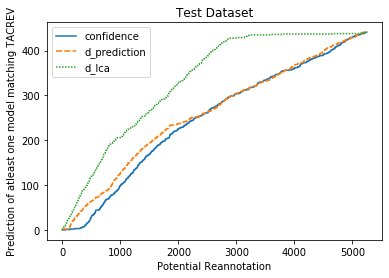

In [54]:
match = pd.DataFrame({'confidence':match_conf, 'd_prediction':match_dpred, 'd_lca':match_dlca})
plt.figure()
sns.lineplot(data=match)
plt.ylabel('Prediction of atleast one model matching TACREV')
plt.xlabel('Potential Reannotation')
plt.title('Test Dataset')

In [55]:
tacrev_test[tacrev_test['relation'] != 0]

,sentence_id,relation
4,098f665fb9b90ac0a09c,9
8,098f665fb9d08796cdd6,27
13,098f665fb9bdd6f6c988,10
14,098f665fb963d544734b,1
22,098f6eb6b0ebc8717d63,9
...,...,...
930,098f665fb9e45d787245,21
931,098f64ffc90811980f0f,6
932,098f665fb95d9daccf2d,3
933,098f665fb9db10b56707,3


## Dev Data

In [56]:
tacrev_dev = pd.read_json('./tacrev_patch/dev_patch.json')
tacrev_dev['relation'] = [LABEL_TO_ID[rel] for rel in list(tacrev_dev['relation'])]
tacrev_dev = tacrev_dev.rename(columns={'id':'sentence_id'})
tacrev_dev

,sentence_id,relation
0,e7798cd9013281a16790,0
1,e779865fb94919ad3d94,23
2,e7798f12fdfa3a0e3698,0
3,e779865fb9bc3619f614,1
4,e779865fb966ebed1fe1,11
...,...,...
1585,e7798ae9c08bf39cfe1b,0
1586,e7798f318b73cf335067,11
1587,e779889f6039db57be54,0
1588,e7798b11b9f18a5a5d16,0


In [57]:
td_dict = dict(zip(tacrev_dev.sentence_id, tacrev_dev.relation))
td_dict

{'e7798cd9013281a16790': 0,
 'e779865fb94919ad3d94': 23,
 'e7798f12fdfa3a0e3698': 0,
 'e779865fb9bc3619f614': 1,
 'e779865fb966ebed1fe1': 11,
 'e7798a9e36cff3265b9e': 26,
 'e779865fb98c83ea3c65': 22,
 'e779889f60c723913859': 0,
 'e779865fb90c3048d5e9': 6,
 'e779865fb9d8e7747d1e': 26,
 'e779865fb9584c91c9ac': 5,
 'e7798f318bd05deb73ce': 11,
 'e779865fb94a96c006f5': 3,
 'e779865fb95edaa4c5bd': 0,
 'e779845ea60a94c7eabe': 0,
 'e7798eb6b0aa80aca46c': 0,
 'e7798784e775f4374db1': 0,
 'e77983793578a79e1654': 0,
 'e779865fb94800c0266e': 1,
 'e7798f12fdede4846ba9': 16,
 'e7798f318b65a2037bc2': 11,
 'e77980af8f45664a8c88': 34,
 'e77980af8f04ab458238': 0,
 'e7798df7f9be7d401386': 34,
 'e779865fb9568a7c058f': 4,
 'e779865fb90f96b52720': 1,
 'e779865fb95354bc3e87': 1,
 'e7798f7060f7def00411': 4,
 'e779865fb966ff8bac91': 11,
 'e779889f6087c0bf61d6': 0,
 'e779865fb9c24a8dc912': 3,
 'e779865fb90ee7f39461': 4,
 'e779865fb937226d9fc5': 38,
 'e779865fb90bfde0d0fd': 31,
 'e7798c74c5a80bd66368': 4,
 'e7798

In [58]:
match_conf_dev = []
count = 0
for i, sid in enumerate(sorted_dfconf_dev.sentence_id):
    parnn_pred = int(df1_dev[df1_dev['sentence_id'] == sid]['prediction'])
    lstm_pred = int(df2_dev[df2_dev['sentence_id'] == sid]['prediction'])
    cgcn_pred = int(df3_dev[df3_dev['sentence_id'] == sid]['prediction'])
    if sid in td_dict:
        reannotation = td_dict[sid]
        if reannotation == parnn_pred or reannotation == lstm_pred or reannotation == cgcn_pred:
            count += 1
            print(i, reannotation, count)
    match_conf_dev.append(count)

95 0 1
97 0 2
183 0 3
195 0 4
295 0 5
490 0 6
548 0 7
555 0 8
565 0 9
570 0 10
573 0 11
587 0 12
594 0 13
596 0 14
626 0 15
629 0 16
632 0 17
640 0 18
656 0 19
661 0 20
665 0 21
668 0 22
680 0 23
683 0 24
690 0 25
702 0 26
708 0 27
711 0 28
722 0 29
725 0 30
748 0 31
760 0 32
761 0 33
767 0 34
788 0 35
823 0 36
827 0 37
829 0 38
833 0 39
846 0 40
852 0 41
858 0 42
866 0 43
868 0 44
869 0 45
870 0 46
873 0 47
874 0 48
893 0 49
898 0 50
910 27 51
912 0 52
916 0 53
957 0 54
959 0 55
960 0 56
992 0 57
998 0 58
1002 0 59
1020 0 60
1023 0 61
1026 0 62
1033 0 63
1034 0 64
1037 0 65
1039 0 66
1046 0 67
1059 0 68
1063 0 69
1069 0 70
1107 0 71
1108 0 72
1119 0 73
1121 0 74
1141 0 75
1143 0 76
1155 0 77
1160 0 78
1165 0 79
1172 0 80
1180 0 81
1181 0 82
1199 0 83
1219 0 84
1225 0 85
1231 0 86
1271 0 87
1272 0 88
1279 0 89
1284 0 90
1286 0 91
1293 0 92
1305 0 93
1320 0 94
1331 0 95
1334 0 96
1369 0 97
1373 0 98
1374 0 99
1376 0 100
1378 0 101
1382 0 102
1384 0 103
1389 0 104
1398 0 105
1402 0 106
1

In [59]:
match_dpred_dev = []
count = 0
for i, sid in enumerate(sorted_df_pd_dev.sentence_id):
    parnn_pred = int(df1_dev[df1_dev['sentence_id'] == sid]['prediction'])
    lstm_pred = int(df2_dev[df2_dev['sentence_id'] == sid]['prediction'])
    cgcn_pred = int(df3_dev[df3_dev['sentence_id'] == sid]['prediction'])
    if sid in td_dict:
        reannotation = td_dict[sid]
        if reannotation == parnn_pred or reannotation == lstm_pred or reannotation == cgcn_pred:
            count += 1
            print(i, reannotation, count)
    match_dpred_dev.append(count)

21 0 1
25 0 2
31 0 3
192 0 4
194 0 5
196 0 6
206 0 7
207 0 8
210 0 9
213 0 10
217 0 11
221 0 12
223 0 13
226 0 14
227 0 15
230 0 16
241 0 17
246 0 18
250 0 19
252 0 20
257 0 21
259 0 22
262 0 23
263 0 24
264 0 25
279 0 26
285 0 27
288 0 28
290 0 29
292 0 30
293 0 31
297 0 32
307 0 33
338 0 34
341 0 35
343 0 36
346 0 37
373 0 38
376 0 39
382 0 40
390 0 41
391 0 42
394 0 43
397 0 44
410 0 45
432 0 46
440 0 47
462 0 48
468 0 49
473 0 50
476 0 51
480 0 52
483 0 53
487 0 54
496 0 55
497 0 56
499 0 57
502 0 58
506 0 59
512 0 60
515 0 61
520 0 62
524 0 63
544 0 64
553 0 65
556 0 66
572 0 67
595 0 68
601 0 69
603 0 70
616 0 71
629 0 72
636 0 73
650 0 74
653 0 75
663 0 76
670 0 77
694 0 78
701 0 79
736 0 80
766 0 81
768 0 82
770 0 83
771 0 84
780 0 85
795 0 86
813 0 87
820 0 88
822 0 89
825 0 90
827 0 91
830 0 92
849 0 93
881 0 94
883 0 95
890 0 96
897 0 97
923 0 98
929 0 99
932 0 100
944 0 101
960 0 102
975 0 103
979 0 104
982 0 105
995 0 106
996 0 107
1006 0 108
1012 0 109
1014 0 110
1022 0 1

In [60]:
match_dlca_dev = []
count = 0
for i, sid in enumerate(sorted_dflca_dev.sentence_id):
    parnn_pred = int(df1_dev[df1_dev['sentence_id'] == sid]['prediction'])
    lstm_pred = int(df2_dev[df2_dev['sentence_id'] == sid]['prediction'])
    cgcn_pred = int(df3_dev[df3_dev['sentence_id'] == sid]['prediction'])
    if sid in td_dict:
        reannotation = td_dict[sid]
        if reannotation == parnn_pred or reannotation == lstm_pred or reannotation == cgcn_pred:
            count += 1
            print(i, reannotation, parnn_pred, lstm_pred, cgcn_pred, count)
    match_dlca_dev.append(count)

0 0 0 0 0 1
7 0 0 0 0 2
10 0 0 0 0 3
25 0 0 0 0 4
27 0 0 0 0 5
33 0 0 0 0 6
37 0 0 0 0 7
44 0 0 0 0 8
52 0 0 0 0 9
53 0 0 0 0 10
54 0 0 0 0 11
63 0 0 0 0 12
82 0 0 0 0 13
84 0 0 0 0 14
94 0 0 0 0 15
101 0 0 0 0 16
106 0 0 0 0 17
112 0 0 0 0 18
114 0 0 0 0 19
116 0 0 0 0 20
117 0 0 0 0 21
123 0 0 0 0 22
134 0 0 0 0 23
136 0 0 0 0 24
148 0 0 0 0 25
160 0 0 0 0 26
163 0 0 0 0 27
171 0 0 0 0 28
174 0 0 0 0 29
179 0 0 0 0 30
191 0 0 0 0 31
194 0 0 0 0 32
202 0 0 0 0 33
209 0 0 0 0 34
211 0 0 0 0 35
220 0 0 0 0 36
228 0 0 0 0 37
230 0 0 0 0 38
252 0 0 0 0 39
260 0 0 0 0 40
265 0 0 0 0 41
266 0 0 0 0 42
268 0 0 0 0 43
283 0 0 0 0 44
287 0 0 0 0 45
288 0 0 0 0 46
289 0 0 0 0 47
292 0 0 0 0 48
293 0 0 0 0 49
294 0 0 0 0 50
301 0 0 0 0 51
303 0 0 0 0 52
304 0 0 0 0 53
305 0 0 0 0 54
307 0 0 0 0 55
309 0 0 0 0 56
316 0 0 0 0 57
317 0 0 0 0 58
320 0 0 0 0 59
325 0 0 0 0 60
341 0 0 0 0 61
342 0 0 0 0 62
350 0 0 0 0 63
351 0 0 0 0 64
359 0 0 0 0 65
362 0 0 0 0 66
366 0 0 0 0 67
375 0 0 0 0 68
377 0 

3612 0 0 0 0 508
3633 0 0 0 0 509
3659 0 0 0 0 510
3662 0 0 0 0 511
3668 0 0 0 0 512
3673 0 0 0 0 513
3697 0 0 0 0 514
3708 0 0 0 0 515
3718 0 0 0 0 516
3724 0 0 0 0 517
3727 0 0 0 0 518
3740 0 0 0 0 519
3770 0 0 0 0 520
3779 0 0 0 0 521
3796 0 0 0 0 522
3810 0 0 0 0 523
3820 0 0 0 0 524
3849 0 0 0 0 525
3850 0 0 0 0 526
3859 0 0 0 0 527
3863 0 0 0 0 528
3869 0 0 0 0 529
3879 0 0 0 0 530
3880 0 0 0 0 531
3886 0 0 0 0 532
3889 0 0 0 0 533
3912 0 0 0 0 534
3934 0 0 0 0 535
3944 0 0 0 0 536
3950 0 0 0 0 537
3954 0 0 0 0 538
3989 0 0 0 0 539
4000 0 0 0 0 540
4036 0 0 0 0 541
4045 0 0 0 0 542
4052 0 0 0 0 543
4064 0 0 0 0 544
4075 0 0 3 3 545
4088 0 16 0 0 546
4091 0 2 0 0 547
4096 0 0 0 6 548
4100 0 19 0 19 549
4105 0 0 0 14 550
4106 0 0 0 23 551
4119 0 0 10 0 552
4129 0 21 21 0 553
4133 0 8 0 0 554
4145 0 0 6 0 555
4149 0 27 0 0 556
4153 0 0 15 0 557
4155 0 3 3 0 558
4165 0 42 0 0 559
4179 0 0 0 6 560
4208 0 1 0 0 561
4211 0 23 0 0 562
4220 0 8 0 0 563
4225 0 21 21 0 564
4236 0 3 3 0 565


Text(0.5, 1.0, 'Dev Dataset')

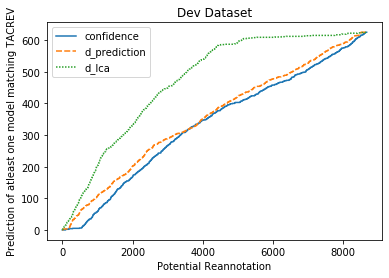

In [61]:
dev_match = pd.DataFrame({'confidence':match_conf_dev, 'd_prediction':match_dpred_dev, 'd_lca':match_dlca_dev})
plt.figure()
sns.lineplot(data=dev_match)
plt.ylabel('Prediction of atleast one model matching TACREV')
plt.xlabel('Potential Reannotation')
plt.title('Dev Dataset')